# UDS emulator 

## Preliminaries

In [1]:
num_events_training     = 50
num_events_validation   = 1
steps_ahead             = 1

epochs = 10

In [2]:
from my_imports import *

In [3]:
Repository('.').head.shorthand

'Expand_Features'

In [4]:
yaml_path = 'config_file.yaml'
yaml_data = utils.load_yaml(yaml_path)

# Directories
training_simulations_path   = yaml_data['training_simulations_path']
validation_simulations_path = yaml_data['validation_simulations_path']

inp_path =  yaml_data['inp_path']

## Create simulation objects from data

In [5]:
list_of_training_simulations    = os.listdir(training_simulations_path)
list_of_validation_simulations  = os.listdir(validation_simulations_path)

random.shuffle(list_of_training_simulations)

print('Number of training simulations: ', len(list_of_training_simulations))
print('Number of validation simulations: ', len(list_of_validation_simulations))


Number of training simulations:  161
Number of validation simulations:  29


In [6]:
# training_simulations = utils.extract_simulations_from_folders(training_simulations_path, inp_path, max_events = num_events_training)

# training_windows = []
# events_to_train= list(range(num_events_training))
# for event in events_to_train:
#     sim = training_simulations[event]
#     training_windows += sim.get_all_windows(steps_ahead = steps_ahead)


In [7]:
with open('pickles\Training_windows.pk', 'rb') as handle:
    training_windows = pickle.load(handle)

In [8]:
validation_simulations = utils.extract_simulations_from_folders(validation_simulations_path, inp_path, max_events =num_events_validation)

# validation_windows = []
# events_to_validate= list(range(num_events_validation))
# for event in events_to_validate:
#     sim = validation_simulations[event]
#     validation_windows += sim.get_all_windows(steps_ahead = steps_ahead)

The file does not have [STORAGE]

The file does not have '[PUMPS]\n'
The file does not have '[ORIFICES]\n'
The file does not have '[WEIRS]\n'


In [9]:
with open('pickles\Validation_windows.pk', 'rb') as handle:
    validation_windows = pickle.load(handle)

In [10]:
print('Number of training windows: ',   len(training_windows))
print('Number of validation windows: ', len(validation_windows))

Number of training windows:  8498
Number of validation windows:  1044


## Normalizer

In [11]:
normalizer = Normalizer(training_windows)

In [12]:
normalized_training_windows = normalizer.get_list_normalized_training_windows()
training_loader = DataLoader(normalized_training_windows, batch_size=32, shuffle = True)

In [13]:
normalized_validation_windows = [normalizer.normalize_window(val_win) for val_win in validation_windows]
validation_loader = DataLoader(normalized_validation_windows, batch_size=32)

## Training GNN

In [14]:
gnn_model = GNNModel()
gnn_model.load_state_dict(torch.load('pickles/model3_parameters.pt'))

optimizer = optim.Adam(gnn_model.parameters(), lr = 0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
loss_fn   = nn.MSELoss()

In [15]:
# history = train(
#     model = gnn_model,
#     optimizer = optimizer,
#     scheduler = scheduler,
#     loss_fn = loss_fn,
#     train_dl = training_loader,
#     val_dl = validation_loader,
#     epochs = epochs,
#     device = 'cpu',
#     report_freq = 2
#     )


In [16]:
# with open('pickles/model4.pk', 'wb') as handle:
#     pickle.dump(gnn_model, handle)

## Results

In [17]:
# vis.plot_loss(history)

## Using the metamodel

In [18]:
val_event =  validation_simulations[0]

length = val_event.simulation_length
sim_in_window = val_event.get_all_windows(steps_ahead = 1)[0]
norm_sim_in_window = normalizer.normalize_window(sim_in_window)

name_nodes = norm_sim_in_window.name_nodes

swmm_heads_pd       = utils.tensor_heads_to_normalized_pd(sim_in_window['y'],             normalizer, name_nodes)
predicted_heads_pd  = utils.tensor_heads_to_normalized_pd(gnn_model(norm_sim_in_window),  normalizer, name_nodes)

new_x tensor([[0.3480],
        [0.3874],
        [0.3328],
        [0.4019],
        [0.3500],
        [0.3519],
        [0.3500],
        [0.3603],
        [0.3163],
        [0.3714],
        [0.3640],
        [0.3137],
        [0.2948],
        [0.3780],
        [0.3252],
        [0.3779],
        [0.3586],
        [0.4090],
        [0.4043],
        [0.3426],
        [0.3782],
        [0.3558],
        [0.3278],
        [0.1920],
        [0.2271],
        [0.3255],
        [0.3507],
        [0.3837],
        [0.3919],
        [0.3450],
        [0.2849],
        [0.2946],
        [0.3868],
        [0.3822],
        [0.3971],
        [0.4232],
        [0.4292],
        [0.4347],
        [0.2418],
        [0.2862],
        [0.3674],
        [0.3795],
        [0.3662],
        [0.3527],
        [0.3821],
        [0.3700],
        [0.3020],
        [0.3182],
        [0.3400],
        [0.3645],
        [0.3343],
        [0.3493],
        [0.0139],
        [0.3450],
        [0.3355],
    

<AxesSubplot:>

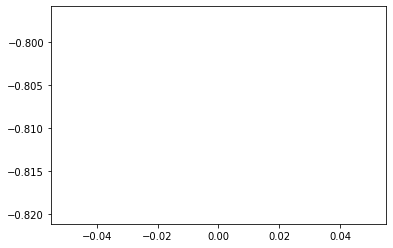

In [19]:
node = name_nodes[24]

swmm_heads_pd[node].plot()
predicted_heads_pd[node].plot()

## Visualization of results

In [ ]:
target      = normalizer.unnormalize_heads(norm_sim_in_window.y)
predicted   = normalizer.unnormalize_heads(gnn_model(norm_sim_in_window).detach())

In [ ]:
pd.DataFrame(target[-1,:].numpy()).plot()
pd.DataFrame(predicted[-1,:].numpy()).plot()

In [ ]:
importlib.reload(vis)

In [ ]:
error = torch.abs(target - predicted)
fig = vis.plot_nodal_variable(error, norm_sim_in_window, 'error in head at time: ', colorscale = 'OrRd')


In [ ]:
norm_sim_in_window.name_nodes[0]

In [ ]:
# fig.write_html('error.html')

In [ ]:
fig = vis.plot_nodal_variable(target, norm_sim_in_window, 'Target Head ', colorscale = 'PuBu', ref_marker_size = 2.5)

# Scratchpad (old)

In [ ]:
zero_cases_simulations_path = yaml_data['zero_cases_simulations_path']
list_of_zero_cases_simulations  = os.listdir(zero_cases_simulations_path)

zero_cases_simulations = utils.extract_simulations_from_folders(zero_cases_simulations_path, inp_path, max_events = 2)


In [ ]:
gnn_model = GNNModel()

In [ ]:
sim_trial = zero_cases_simulations[0]

length = sim_trial.simulation_length
sim_in_window = sim_trial.get_all_windows(steps_ahead = length-2)[0]
norm_sim_in_window = normalizer.normalize_window(sim_in_window)

name_nodes = norm_sim_in_window.name_nodes

swmm_heads_pd       = utils.tensor_heads_to_normalized_pd(sim_in_window['y'],             normalizer, name_nodes)
predicted_heads_pd  = utils.tensor_heads_to_normalized_pd(gnn_model(norm_sim_in_window),  normalizer, name_nodes)

In [ ]:
target      = normalizer.unnormalize_heads(norm_sim_in_window.y)
predicted   = normalizer.unnormalize_heads(gnn_model(norm_sim_in_window).detach())

In [ ]:
pd.DataFrame(target[-1,:].numpy()).plot()
pd.DataFrame(predicted[-1,:].numpy()).plot()

In [ ]:
error = torch.abs(target - predicted)
fig = vis.plot_nodal_variable(error, norm_sim_in_window, 'error in head at time: ', colorscale = 'OrRd')

In [ ]:
norm_sim_in_window.name_nodes[0]

In [ ]:
# fig.write_html('error.html')

In [ ]:
fig = vis.plot_nodal_variable(target, norm_sim_in_window, 'Target Head ', colorscale = 'PuBu', ref_marker_size = 2.5)

# Scratchpad (new)

In [20]:
val_event =  validation_simulations[0]
event_in_windows = val_event.get_all_windows(steps_ahead=1)

In [21]:
norm_event_in_windows = [normalizer.normalize_window(window) for window in event_in_windows]

In [22]:
results = []
for i in norm_event_in_windows:
    results.append(gnn_model(i))

new_x tensor([[0.3480],
        [0.3874],
        [0.3328],
        [0.4019],
        [0.3500],
        [0.3519],
        [0.3500],
        [0.3603],
        [0.3163],
        [0.3714],
        [0.3640],
        [0.3137],
        [0.2948],
        [0.3780],
        [0.3252],
        [0.3779],
        [0.3586],
        [0.4090],
        [0.4043],
        [0.3426],
        [0.3782],
        [0.3558],
        [0.3278],
        [0.1920],
        [0.2271],
        [0.3255],
        [0.3507],
        [0.3837],
        [0.3919],
        [0.3450],
        [0.2849],
        [0.2946],
        [0.3868],
        [0.3822],
        [0.3971],
        [0.4232],
        [0.4292],
        [0.4347],
        [0.2418],
        [0.2862],
        [0.3674],
        [0.3795],
        [0.3662],
        [0.3527],
        [0.3821],
        [0.3700],
        [0.3020],
        [0.3182],
        [0.3400],
        [0.3645],
        [0.3343],
        [0.3493],
        [0.0139],
        [0.3450],
        [0.3355],
    

In [23]:
prediction = torch.cat(results, axis = 1)
unnormalized_prediction = normalizer.unnormalize_heads(prediction)

In [24]:
val_event =  validation_simulations[0]

length = val_event.simulation_length
sim_in_window = val_event.get_all_windows(steps_ahead = length-2)[0]
norm_sim_in_window = normalizer.normalize_window(sim_in_window)

name_nodes = norm_sim_in_window.name_nodes

swmm_heads_pd       = utils.tensor_heads_to_normalized_pd(sim_in_window['y'],             normalizer, name_nodes)

In [25]:
norm_sim_in_window

Data(edge_index=[2, 706], pos=[318, 2], elevation=[318], name_nodes=[318], name_subcatchment=[318], raingage=[318], area_subcatchment=[318], h_x=[318, 1], runoff=[318, 115], h_y=[318, 115], name_conduits=[706], length=[706], roughness=[706], in_offset=[706], out_offset=[706], conduit_shape=[706], geom_1=[706], geom_2=[706], steps_ahead=115, x=[318, 116], y=[318, 115], norm_elev=[318, 1], norm_geom_1=[706, 1], norm_length=[706, 1], norm_in_offset=[706, 1], norm_out_offset=[706, 1])

In [26]:
rollout_results = gnn_model(norm_sim_in_window)
unnormalized_rollout = normalizer.unnormalize_heads(rollout_results)

new_x tensor([[0.3480, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3874, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3328, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.5248, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0893, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0107, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<CatBackward0>)
new_x.shape torch.Size([318, 115])
new_x tensor([[0.3468, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3838, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3304, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.5134, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0892, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0173, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<CatBackward0>)
new_x.shape torch.Size([318, 114])
new_x tensor([[0.3457, 0.0000, 0.0000,  ..., 0.0000, 0.0000,

Node:  0


<AxesSubplot:>

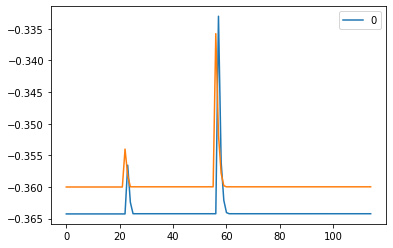

In [28]:
node =0 #np.random.randint(0, 300)
print('Node: ', node)
pd.DataFrame(unnormalized_prediction[node,:].detach().numpy()).plot()
swmm_heads_pd.iloc[:,node].plot()


<AxesSubplot:>

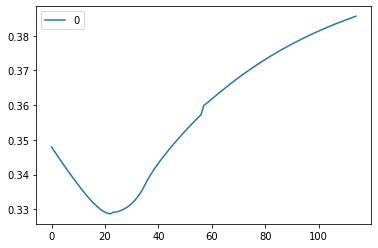

In [30]:
pd.DataFrame(rollout_results[node,:].detach().numpy()).plot()